In [1]:
import torch
import torch.nn as nn

## Parameters

In [2]:
BATCH_SIZE = 1

IMAGE_SIZE = 384
IN_CHANNELS = 3
SEQ_LENGTH = 30
VOCAB_SIZE = 32100

EMBED_DIM = 768
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

NUM_ENCODER_BLOCKS = 12
NUM_DECODER_BLOCKS = 4
NUM_HEADS = 12
HIDDEN_DIM = EMBED_DIM * 4
DROP_PROB = 0.1

## Encoder

### Patch Embedding

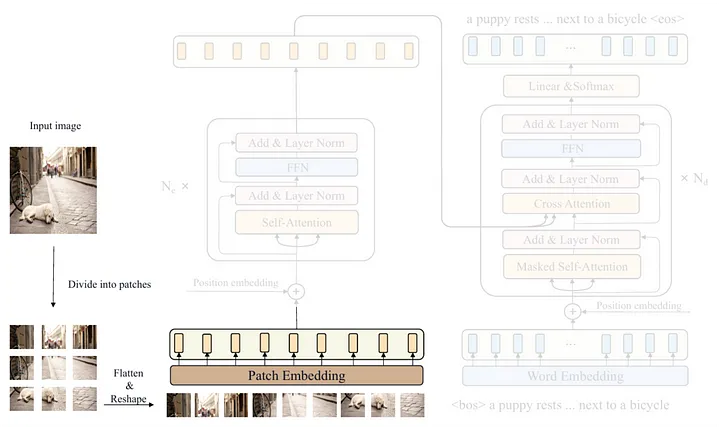

**This is essentially done because instead of focusing on local patterns like CNNs, ViT captures global context by *learning the relationships between these patches.***

In [3]:
class Patcher(nn.Module):
  def __init__(self):
    super().__init__()

    # 1.
    self.unfold = nn.Unfold(kernel_size=PATCH_SIZE, stride=PATCH_SIZE)

    # 2.
    self.linear_projection = nn.Linear(in_features=IN_CHANNELS * PATCH_SIZE *  PATCH_SIZE,
                                       out_features=EMBED_DIM)

  def forward(self, images):
    # print(f'Images\t\t: {images.size()}')

    images = self.unfold(images)
    # print(f'After Unfold\t: {images.size()}')

    images = images.permute(0, 2, 1)
    # print(f'After Permute\t: {images.size()}')

    features = self.linear_projection(images)
    # print(f'After Lin Proj\t: {features.size()}')

    return features

In [4]:
patcher = Patcher()

images = torch.randn(BATCH_SIZE, IN_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
features = patcher(images)


Let’s use a **small grayscale image** (1 channel) to see how `nn.Unfold` behaves.

 Input:
- Shape: `(B=1, C=1, H=4, W=4)` (batch size=1, channels=1, height=4, width=4).
- Pixel values (for clarity):
  ```
  [[1,  2,  3,  4],
   [5,  6,  7,  8],
   [9, 10, 11, 12],
   [13, 14, 15, 16]]
  ```

 Unfold Parameters:
- `kernel_size=2` (2×2 patches).
- `stride=2` (non-overlapping patches).

 Step 1: Extract Patches
The image is divided into 2×2 non-overlapping patches:
1. Top-left patch: `[[1, 2], [5, 6]]` → Flattened to `[1, 2, 5, 6]`.
2. Top-right patch: `[[3, 4], [7, 8]]` → `[3, 4, 7, 8]`.
3. Bottom-left patch: `[[9, 10], [13, 14]]` → `[9, 10, 13, 14]`.
4. Bottom-right patch: `[[11, 12], [15, 16]]` → `[11, 12, 15, 16]`.

 Step 2: Output Shape
- Number of patches: `(4 // 2) * (4 // 2) = 4`.
- Flattened patch size: `C * kernel_size * kernel_size = 1 * 2 * 2 = 4`.
- Output shape: `(B=1, 4, 4)` (batch, flattened patches, num_patches).

 Output Tensor:
```
[
  [ [1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 13, 14], [11, 12, 15, 16] ]
]
```

---

 How This Applies to the `Patcher` Class:
1. **Input Image**: `(B=1, C=3, H=384, W=384)`.
2. **Unfold**:
   - Extracts `16x16` patches → `576` total patches (`24x24` grid).
   - Each patch is flattened to `3*16*16 = 768` values.
   - Output shape: `(1, 768, 576)`.
3. **Permute**: Swaps axes to `(1, 576, 768)` (sequence of 576 patches, each 768-dim).
4. **Linear Projection**: Maps each `768`-dim patch to `EMBED_DIM=768` (identity if weights allow).

### Positional Embedding

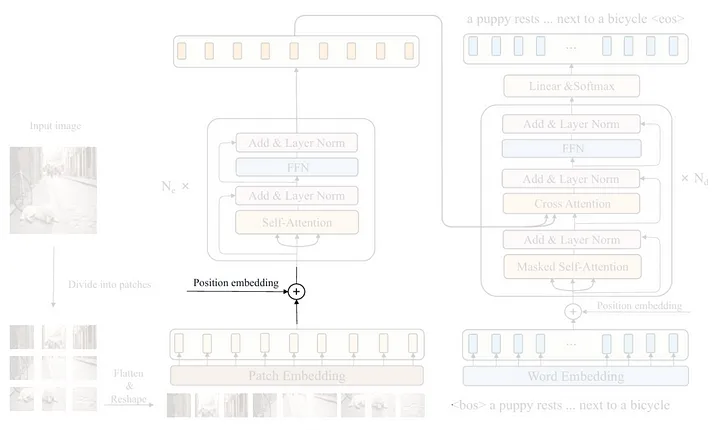

- After the input image has successfully been converted into a sequence of patches, the next thing to do is to inject the so-called **positional embedding tensor**.

- This is essentially done because a transformer without positional embedding is **permutation-invariant**, meaning that it treats the input sequence as if their order does not matter.

- Interestingly, since an image is not a literal sequence, we should set the **positional embedding to be learnable** such that it will be able to somewhat reorder the patch sequence that it thinks works best in representing the spatial information.

> All we need to do is just to initialize a tensor using `nn.Parameter` which the dimension is **set to match with the output from the Patcher model**,
i.e., 576×768.

Also, don’t forget to write `requires_grad=True` just to ensure that the tensor is *trainable*.

In [5]:
class LearnableEmbedding(nn.Module):
  def __init__(self):
    super().__init__()

    self.learnable_embedding = nn.Parameter(torch.randn(size=(NUM_PATCHES, EMBED_DIM)), requires_grad=True)

  def forward(self):
    pos_embed = self.learnable_embedding
    # print(f'Learnable Embedding\t: {pos_embed.size()}')

    return pos_embed

In [6]:
learnable_embedding = LearnableEmbedding()
pos_embed = learnable_embedding()

### Main Encoder Block

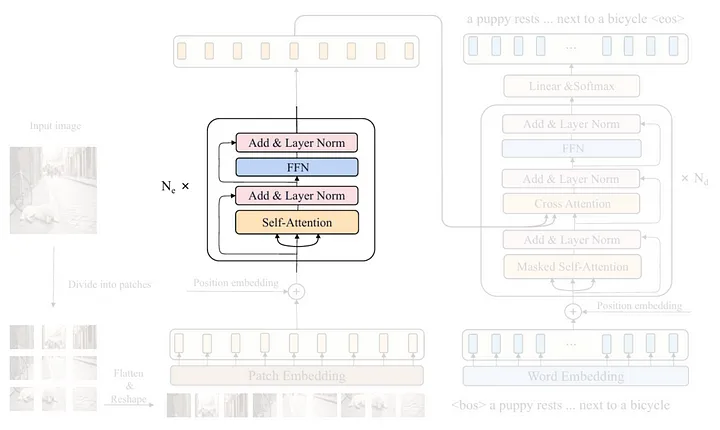

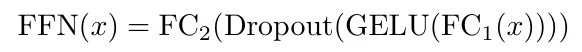

In [7]:
class EncoderBlock(nn.Module):
  def __init__(self):
    super().__init__()

    # 1.
    self.self_attention = nn.MultiheadAttention(
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        batch_first=True,
        dropout=DROP_PROB,
    )

    # 2.
    self.layer_norm_0 = nn.LayerNorm(EMBED_DIM)

    # 3.
    self.ffn = nn.Sequential(
        nn.Linear(in_features=EMBED_DIM, out_features=HIDDEN_DIM),
        nn.GELU(),
        nn.Dropout(p=DROP_PROB),
        nn.Linear(in_features=HIDDEN_DIM, out_features=EMBED_DIM)
    )

    # 4.
    self.layer_norm_1 = nn.LayerNorm(EMBED_DIM)

  def forward(self, features):

    # 1.
    residual = features
    # print(f'Features & Residuals\t: {residual.size()}')

    # 2.
    features, self_attn_weights = self.self_attention(
        query=features,
        key=features,
        value=features
    )
    # print(f'Features after Self Attention\t: {features.size()}')
    # print(f'Self Attention Weights\t: {self_attn_weights.size()}')

    # 3.
    features = self.layer_norm_0(features + residual)
    # print(f'Features after Layer Norm\t: {features.size()}')

    residual = features
    # print(f'Features & Residuals\t: {residual.size()}')

    # 4.
    features = self.ffn(features)
    # print(f'Features after FFN\t: {features.size()}')

    # 5.
    features = self.layer_norm_1(features + residual)
    # print(f'Features after Layer Norm\t: {features.size()}')

    return features

In [8]:
encoder_block = EncoderBlock()

features = torch.randn(BATCH_SIZE, NUM_PATCHES, EMBED_DIM)
features = encoder_block(features)

Here you can see that the **final output tensor** has the same size as the **input**, allowing us to **stack multiple encoder blocks** without having to worry about messing up the tensor dimensions.

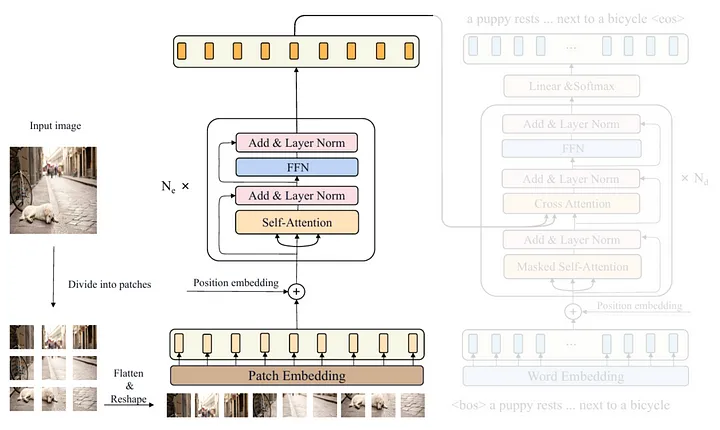

In [9]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    #1.
    self.patcher = Patcher()

    #2.
    self.learnable_embedding = LearnableEmbedding()

    #3.
    self.encoder_blocks = nn.ModuleList(EncoderBlock() for _ in range(NUM_ENCODER_BLOCKS))

  def forward(self, images):
    # print(f'Images\t\t: {images.size()}')

    #1.
    features = self.patcher(images)
    # print(f'After Patcher\t\t: {features.size()}')

    #2.
    features = features + self.learnable_embedding()
    # print(f'After Pos Embedding\t: {features.size()}')

    #3.
    for i, encoder_block in enumerate(self.encoder_blocks):
      features = encoder_block(features)
      # print(f'After Encoder Block #{i}\t: {features.size()}')

    return features

In [10]:
encoder = Encoder()

images = torch.randn(BATCH_SIZE, IN_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
features = encoder(images)

## Decoder

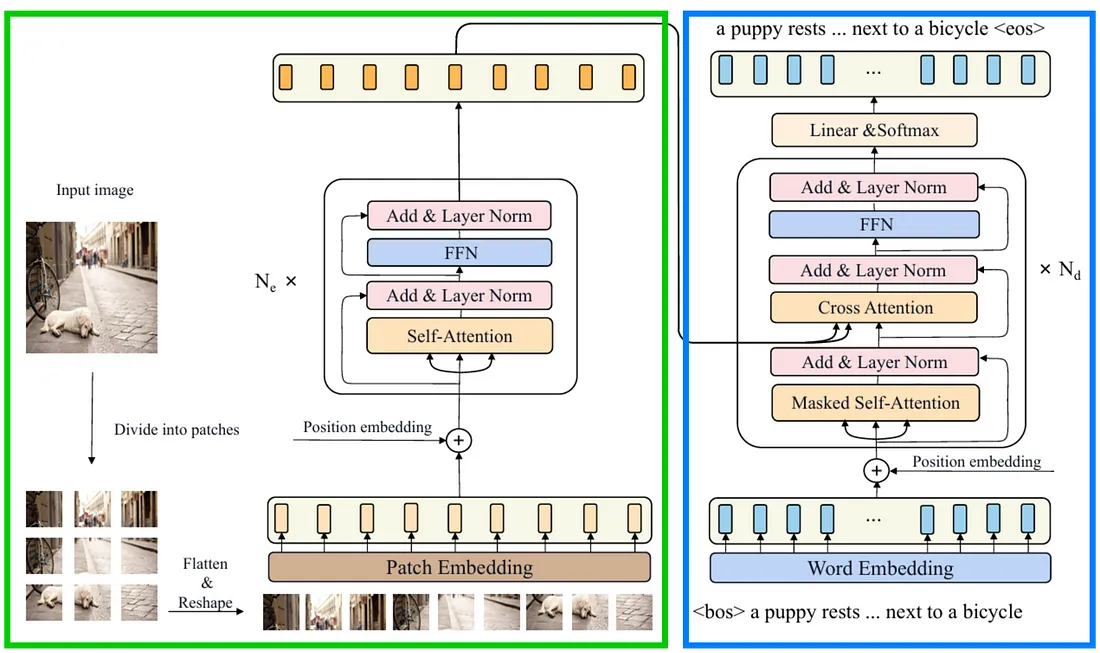

### Sinusoidal Positional Embedding


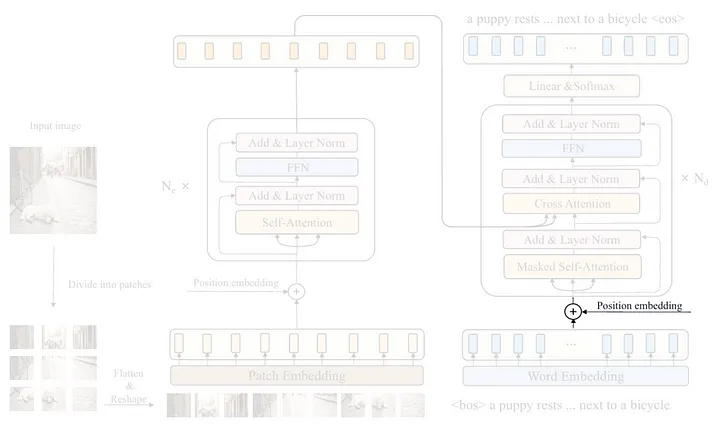

- We can think of it like a method to **label each word vector by assigning numbers** obtained from sinusoidal wave.

- By doing so, we can expect our model to **understand word orders thanks to the information given by the wave patterns**.

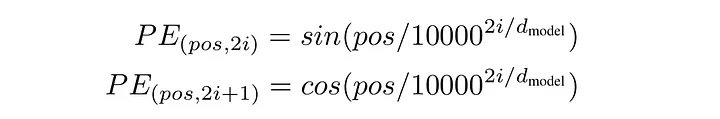

In [11]:
EMBED_DIM

768

In [12]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        # Register buffer to handle device movement automatically
        self.register_buffer('pos_embed', self._create_pos_embed())

    def _create_pos_embed(self):
        pos = torch.arange(SEQ_LENGTH).reshape(SEQ_LENGTH, 1)
        i = torch.arange(0, EMBED_DIM, 2)
        denominator = torch.pow(10000, i/EMBED_DIM)

        even_pos_embed = torch.sin(pos/denominator)
        odd_pos_embed = torch.cos(pos/denominator)

        stacked = torch.stack([even_pos_embed, odd_pos_embed], dim=2)
        pos_embed = torch.flatten(stacked, start_dim=1, end_dim=2)
        return pos_embed

    def forward(self):
        return self.pos_embed

In [13]:
sinusoidal_embedding = SinusoidalEmbedding()
pos_embed= sinusoidal_embedding()

- **Input**: A sequence of length `SEQ_LENGTH` (e.g., 5).
- **Output**: For each position in the sequence, generate a unique `EMBED_DIM`-dimensional vector (e.g., `EMBED_DIM=4`).
- **Method**: Use alternating sine (even indices) and cosine (odd indices) waves with varying frequencies to encode positions.

---

#### Dry Run Example:
Let’s set:
- `SEQ_LENGTH = 5` (sequence has 5 positions: 0, 1, 2, 3, 4).
- `EMBED_DIM = 4` (each position gets a 4D embedding vector).

#### Step 1: Position Tensor (`pos`)
```python
pos = torch.arange(5).reshape(5, 1)  # shape: (5, 1)
```
Output (`pos`):
```
[[0],
 [1],
 [2],
 [3],
 [4]]
```

#### Step 2: Denominator (Frequency Calculation)
```python
i = torch.arange(0, 4, 2)  # i = [0, 2] (even indices of EMBED_DIM)
denominator = torch.pow(10000, i / 4)  # shape: (2,)
```
- For `i = 0`: `10000^(0/4) = 1`
- For `i = 2`: `10000^(2/4) = 100`

Output (`denominator`):
```
[1, 100]
```

#### Step 3: Even/Odd Embeddings
- **Even indices (0, 2)**: Use `sin(pos / denominator)`.
- **Odd indices (1, 3)**: Use `cos(pos / denominator)`.

##### Even Embedding (`sin`):
```python
even_pos_embed = torch.sin(pos / denominator)  # shape: (5, 2)
```
Output:
```
[[sin(0/1), sin(0/100)] = [0.0, 0.0],
 [sin(1/1), sin(1/100)] ≈ [0.84, 0.01],
 [sin(2/1), sin(2/100)] ≈ [0.91, 0.02],
 [sin(3/1), sin(3/100)] ≈ [0.14, 0.03],
 [sin(4/1), sin(4/100)] ≈ [-0.76, 0.04]]
```

##### Odd Embedding (`cos`):
```python
odd_pos_embed = torch.cos(pos / denominator)  # shape: (5, 2)
```
Output:
```
[[cos(0/1), cos(0/100)] = [1.0, 1.0],
 [cos(1/1), cos(1/100)] ≈ [0.54, 0.99],
 [cos(2/1), cos(2/100)] ≈ [-0.42, 0.98],
 [cos(3/1), cos(3/100)] ≈ [-0.99, 0.98],
 [cos(4/1), cos(4/100)] ≈ [-0.65, 0.99]]
```

#### Step 4: Interleave Sine/Cosine
Stack and flatten to interleave even/odd dimensions:
```python
stacked = torch.stack([even_pos_embed, odd_pos_embed], dim=2)  # shape: (5, 2, 2)
pos_embed = torch.flatten(stacked, start_dim=1)  # shape: (5, 4)
```
Final `pos_embed` (5 positions × 4D embeddings):
```
Position 0: [0.0, 1.0, 0.0, 1.0]
Position 1: [0.84, 0.54, 0.01, 0.99]
Position 2: [0.91, -0.42, 0.02, 0.98]
Position 3: [0.14, -0.99, 0.03, 0.98]
Position 4: [-0.76, -0.65, 0.04, 0.99]
```

---

### Why This Works:
1. **Unique Encoding**: Each position gets a unique pattern of sine/cosine values.
2. **Frequency Variation**: Higher dimensions (larger `i`) have slower-changing frequencies (due to `10000^(i/dim)`), capturing coarse-to-fine positional information.
3. **Transformer-Friendly**: The embeddings are deterministic (no learned weights) and generalize to unseen sequence lengths.

---

### Visualization (for `EMBED_DIM=4`):
| Position | Embedding Vector (4D)               |
|----------|-------------------------------------|
| 0        | `[sin(0), cos(0), sin(0), cos(0)]`  |
| 1        | `[sin(1), cos(1), sin(0.01), cos(0.01)]` |
| ...      | ...                                 |

This is how Transformers "know" the order of input sequences!

In [14]:
pos_embed[0], pos_embed[1]

(tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0.,

### Look Ahead Mask

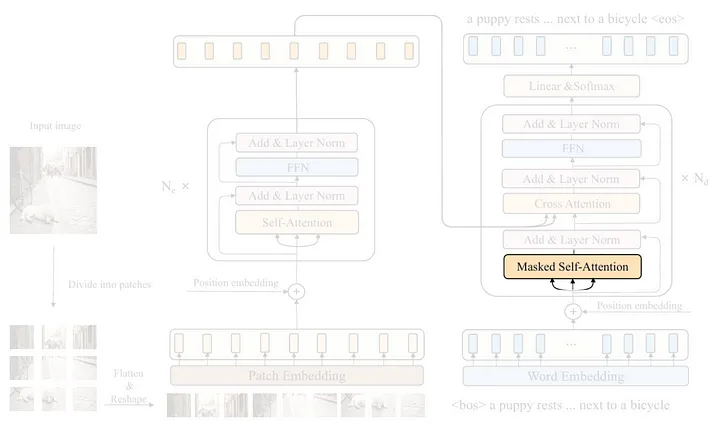

In [15]:
def create_mask(seq_length):
    mask = torch.tril(torch.ones((seq_length, seq_length)))  #(1)
    mask[mask == 0] = -float('inf')  #(2)
    mask[mask == 1] = 0  #(3)
    return mask

This is essentially done because the `nn.MultiheadAttention` layer applies the mask by element-wise addition.

By assigning *`-inf`* to the subsequent words, the attention mechanism will completely **ignore them. **

In [16]:
mask_example = create_mask(seq_length=4)
mask_example

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

### The Main Decoder Block

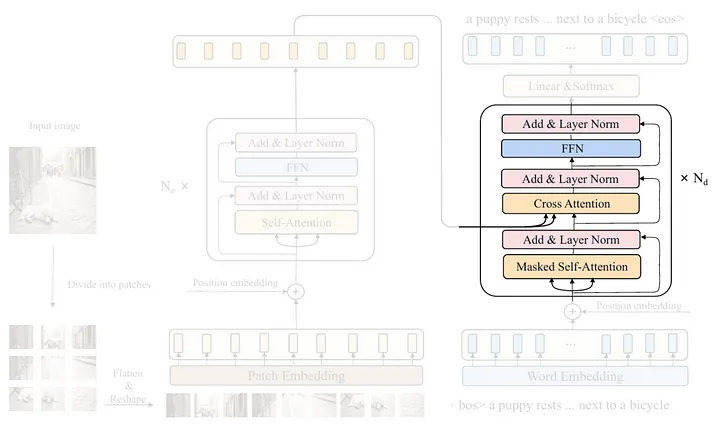

In [17]:
class DecoderBlock(nn.Module):
  def __init__(self):
    super().__init__()

    #1.
    self.self_attention = nn.MultiheadAttention(
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        batch_first=True,
        dropout=DROP_PROB
    )

    #2.
    self.layer_norm_0 = nn.LayerNorm(EMBED_DIM)

    #3.
    self.cross_attention = nn.MultiheadAttention(
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        batch_first=True,
        dropout=DROP_PROB
    )

    #4.
    self.layer_norm_1 = nn.LayerNorm(EMBED_DIM)

    #5.
    self.ffn = nn.Sequential(
        nn.Linear(in_features=EMBED_DIM, out_features=HIDDEN_DIM),
        nn.GELU(),
        nn.Dropout(p=DROP_PROB),
        nn.Linear(in_features=HIDDEN_DIM, out_features=EMBED_DIM),
    )

    #6.
    self.layer_norm_2 = nn.LayerNorm(EMBED_DIM)

  def forward(self, features, captions, attn_mask):
    # print(f'Attention Mask\t\t: {attn_mask.shape}')

    #1.
    residual = captions
    # print(f'Captions & Residuals\t: {captions.shape}')

    #2.
    captions, self_attn_weights = self.self_attention(
        query=captions,
        key=captions,
        value=captions,
        attn_mask=attn_mask,
    )
    # print(f'After Self Attention\t: {captions.shape}')
    # print(f'Self Attention Weights\t: {self_attn_weights.shape}')

    #3.
    captions = self.layer_norm_0(captions + residual)
    # print(f'After Layer Norm 0\t: {captions.shape}')

    #4.
    # print(f'Features from Encoder Block\t: {features.shape}')
    residual = captions
    # print(f'Captions & Residuals\t: {captions.shape}')

    #5.
    captions, cross_attn_weights = self.cross_attention(
        query=captions,
        key=features,
        value=features,
    )
    # print(f'After Cross Attention\t: {captions.shape}')
    # print(f'Cross Attention Weights\t: {cross_attn_weights.shape}')

    #6.
    captions = self.layer_norm_1(captions + residual)
    # print(f'After Layer Norm 1\t: {captions.shape}')

    #7.
    residual = captions
    # print(f'Captions & Residuals\t: {captions.shape}')

    #8.
    captions = self.ffn(captions)
    # print(f'After FFN\t\t: {captions.shape}')

    #9.
    captions = self.layer_norm_2(captions + residual)

    return captions

In [18]:
decoder_block = DecoderBlock()

features = torch.randn(BATCH_SIZE, NUM_PATCHES, EMBED_DIM)  #(1)
captions = torch.randn(BATCH_SIZE, SEQ_LENGTH, EMBED_DIM)   #(2)
look_ahead_mask = create_mask(seq_length=SEQ_LENGTH)  #(3)

captions = decoder_block(features, captions, look_ahead_mask)

In [19]:
captions.shape

torch.Size([1, 30, 768])

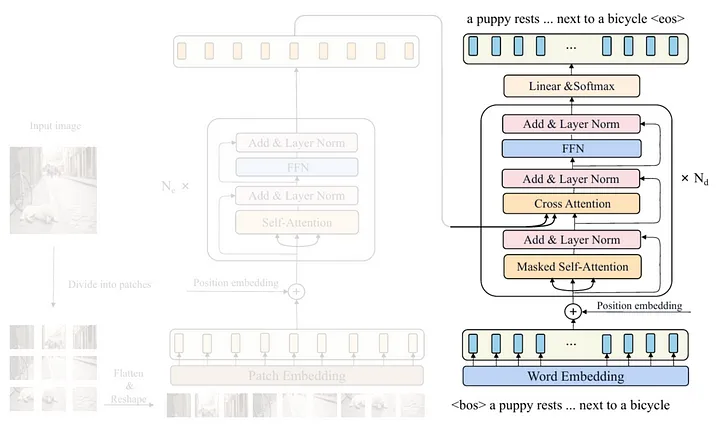

In [20]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

    #1.
    self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_DIM)

    #2.
    self.sinusoidal_embedding = SinusoidalEmbedding()

    #3.
    self.decoder_blocks = nn.ModuleList(DecoderBlock() for _ in range(NUM_DECODER_BLOCKS))

    #4.
    self.linear = nn.Linear(in_features=EMBED_DIM, out_features=VOCAB_SIZE)

  def forward(self, features, captions, attn_mask):
    # print(f'Features\t\t: {features.shape}')
    # print(f'Captions\t\t: {captions.shape}')

    captions = self.embedding(captions)
    # print(f'Captions after Embedding\t: {captions.shape}')

    captions = captions + self.sinusoidal_embedding()
    # print(f'Captions after Sinusoidal Embedding\t: {captions.shape}')

    for i, decoder_block in enumerate(self.decoder_blocks):
      captions = decoder_block(features, captions, attn_mask)  #(4)
      # print(f"After decoder block #{i}\t: {captions.shape}")

    captions = self.linear(captions)  #(5)
    # print(f"After linear\t\t: {captions.shape}")

    return captions

In [21]:
decoder = Decoder()

features = torch.randn(BATCH_SIZE, NUM_PATCHES, EMBED_DIM)
captions = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, SEQ_LENGTH))  #(1)

captions = decoder(features, captions, look_ahead_mask)

In [22]:
captions.shape

torch.Size([1, 30, 32100])

## CPTR Model

In [23]:
class EncoderDecoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, images, captions, look_ahead_mask):
    # print(f"Images\t\t\t: {images.shape}")
    # print(f"Captions\t\t: {captions.shape}")

    features = self.encoder(images)
    # print(f"After Encoder\t\t: {features.shape}")

    captions = self.decoder(features, captions, look_ahead_mask)
    # print(f"After Decoder\t\t: {captions.shape}")

    return captions

In [24]:
encoder_decoder = EncoderDecoder()

images = torch.randn(BATCH_SIZE, IN_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)  #(1)
captions = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, SEQ_LENGTH))  #(2)

captions = encoder_decoder(images, captions, look_ahead_mask)

In [25]:
captions.shape

torch.Size([1, 30, 32100])

## Training

In [26]:
!pip install datasets transformers torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
from datasets import load_dataset
from transformers import AutoTokenizer
from torchvision import transforms
from PIL import Image
import requests
import torch

In [28]:
from datasets import load_dataset

subset_size = 1000
dataset = load_dataset("tsystems/flickr8k", split="train").select(range(subset_size))

README.md:   0%|          | 0.00/492 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8091 [00:00<?, ? examples/s]

In [29]:
dataset.column_names, dataset.shape

(['image', 'image_filename', 'captions', 'query'], (1000, 4))

In [30]:
from transformers import AutoTokenizer
from torchvision import transforms

tokenizer = AutoTokenizer.from_pretrained("t5-small")

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

SEQ_LENGTH = 30

def preprocess(example):
    image = transform(example["image"])
    caption = example["captions"][0]

    tokens = tokenizer(
        caption,
        padding="max_length",
        truncation=True,
        max_length=SEQ_LENGTH + 1,
        return_tensors="pt"
    )

    return {
        "pixel_values": image,
        "input_ids": tokens["input_ids"].squeeze(0)
    }

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [31]:
processed_dataset = dataset.map(preprocess)
processed_dataset.set_format(type='torch', columns=['pixel_values', 'input_ids'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [32]:
from torch.utils.data import DataLoader
dataloader = DataLoader(processed_dataset, batch_size=1, shuffle=True)

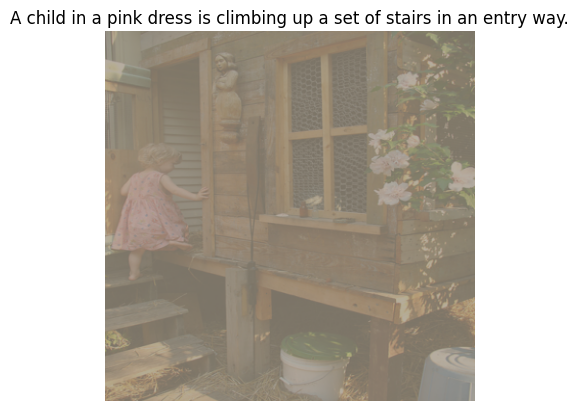

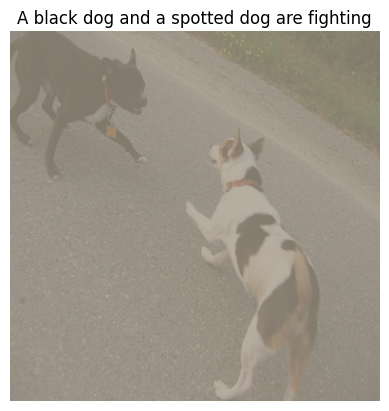

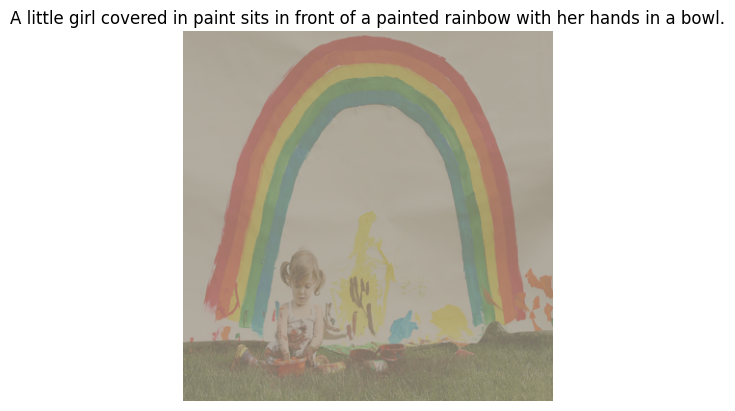

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# Convert tensor back to PIL image
inv_transform = T.Compose([
    T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    T.ToPILImage()
])

for i in range(3):
    sample = processed_dataset[i]
    image_tensor = sample["pixel_values"]
    input_ids = sample["input_ids"]

    # Decode caption
    caption = tokenizer.decode(input_ids, skip_special_tokens=True)

    # Convert tensor back to image
    image = inv_transform(image_tensor)

    # Display
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bars

# Initialize model
model = EncoderDecoder()
device = torch.device("cuda")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 10

In [35]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        # Get batch data
        images = batch["pixel_values"].to(device)
        captions = batch["input_ids"].to(device)

        # Create masks
        look_ahead_mask = torch.triu(
            torch.ones(SEQ_LENGTH, SEQ_LENGTH), diagonal=1
        ).bool().to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, captions[:, :-1], look_ahead_mask)

        # Calculate loss
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            captions[:, 1:].reshape(-1)
        )

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

Epoch 1/10: 100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s, loss=2.2936]


Epoch 1 Loss: 4.4092


Epoch 2/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s, loss=3.4872]


Epoch 2 Loss: 3.2556


Epoch 3/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s, loss=2.5258]


Epoch 3 Loss: 2.6390


Epoch 4/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s, loss=2.6210]


Epoch 4 Loss: 2.1090


Epoch 5/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s, loss=1.6717]


Epoch 5 Loss: 1.6416


Epoch 6/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s, loss=1.4953]


Epoch 6 Loss: 1.2867


Epoch 7/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s, loss=1.2981]


Epoch 7 Loss: 1.0155


Epoch 8/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s, loss=1.0724]


Epoch 8 Loss: 0.8626


Epoch 9/10: 100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s, loss=1.2829]


Epoch 9 Loss: 0.7802


Epoch 10/10: 100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s, loss=0.9987]

Epoch 10 Loss: 0.7390


In [67]:
from torchvision.transforms.functional import to_pil_image
from transformers import AutoTokenizer
import PIL

In [72]:
sample = next(iter(dataloader))

In [73]:
images = batch["pixel_values"].to(device)
captions = batch["input_ids"].to(device)

# Create masks
look_ahead_mask = torch.triu(
  torch.ones(SEQ_LENGTH, SEQ_LENGTH), diagonal=1
).bool().to(device)

print(images), print(captions)

tensor([[[[0.4392, 0.3882, 0.3255,  ..., 0.2471, 0.2549, 0.2549],
          [0.4196, 0.4510, 0.4039,  ..., 0.2392, 0.2157, 0.2196],
          [0.3882, 0.3725, 0.3961,  ..., 0.1804, 0.1608, 0.1765],
          ...,
          [0.6941, 0.6824, 0.6902,  ..., 0.5686, 0.5686, 0.5686],
          [0.6314, 0.6980, 0.7216,  ..., 0.5686, 0.5647, 0.5647],
          [0.6627, 0.6549, 0.7020,  ..., 0.5647, 0.5647, 0.5647]],

         [[0.4745, 0.4235, 0.3804,  ..., 0.2510, 0.2588, 0.2471],
          [0.4196, 0.4784, 0.4392,  ..., 0.2353, 0.2118, 0.2118],
          [0.4275, 0.4039, 0.4275,  ..., 0.2078, 0.1882, 0.1922],
          ...,
          [0.7020, 0.6824, 0.7059,  ..., 0.5490, 0.5490, 0.5490],
          [0.6588, 0.7333, 0.7059,  ..., 0.5490, 0.5451, 0.5451],
          [0.6706, 0.6706, 0.7216,  ..., 0.5451, 0.5451, 0.5451]],

         [[0.4941, 0.4431, 0.4000,  ..., 0.2588, 0.2667, 0.2667],
          [0.4510, 0.5020, 0.4588,  ..., 0.2549, 0.2314, 0.2353],
          [0.4745, 0.4510, 0.4706,  ..., 0

(None, None)

In [74]:
decoded_caption = tokenizer.decode(
    captions.squeeze(0),
    skip_special_tokens=True
)

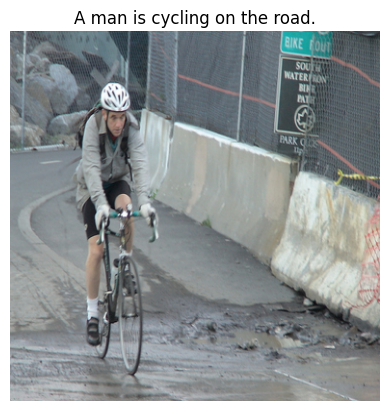

In [75]:
pil_image = to_pil_image(images.squeeze(0))
plt.imshow(pil_image)
plt.axis('off')
plt.title(decoded_caption)
plt.show()